# Self-Driving Car Engineer Nanodegree


## Project:Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Important Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
import os
import glob
from PIL import Image
%matplotlib inline

## Main functions, classes


In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
    
    def fit_on(self,newBestFit):
        danger = False
        if newBestFit is not None:
            self.best_fit=newBestFit
        '''
        if self.best_fit is not None:
            
            #print("f1",(abs(self.best_fit[0]-newBestFit[0])))
            abs1 = abs(self.best_fit[0]-newBestFit[0])
            print("fit1 danger",abs1 )
            if ( abs1 > 60.1 or abs1 < 0.01):
                danger = True
            else:
                #self.best_fit[0]=newBestFit[0]
                self.best_fit=newBestFit
            #print("f2",(abs(self.best_fit[0]-newBestFit[0])))
            abs2=abs(self.best_fit[1]-newBestFit[1])
            print("fit2 danger",abs2 )
            if ( abs2 > 60.1 or abs2 < 0.01):
                danger = True
            else:
                #self.best_fit[1]=newBestFit[1]
                self.best_fit=newBestFit
            #print("f3",(abs(self.best_fit[0]-newBestFit[0])))
            abs3=abs(self.best_fit[2]-newBestFit[2])
            print("fit3 danger",abs3 )
            if (abs3 > 60.1 or abs3 <0.01): 
                danger = True
            #else:
                #self.best_fit[2]=newBestFit[2]
                #self.best_fit=newBestFit
        if not danger:
        
            self.best_fit=newBestFit
        '''
            
    def isGood(self,newToFit):
        self.diffs=abs(self.best_fit-newToFit)
        print(diffs)
        

#Helper function to load image files //TODO map would be better
def loadImagesFromFolder(folder,listOfExtensions):
    images = ()
    for extension in listOfExtensions:
        imagePath = folder+"/*."+extension
        imgs=glob.glob(imagePath);
        images+=tuple(imgs)                  
    return list(images)

def unwarp(imgP, srcPo, dstPo):
    h,w = imgP.shape[:2]
    M = cv2.getPerspectiveTransform(srcPo, dstPo)
    #Minv = cv2.getPerspectiveTransform(dst, src)
    warpedImage = cv2.warpPerspective(imgP, M, (w,h), flags=cv2.INTER_LINEAR)
    return warpedImage, M

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def showOriginalAndUndistortedImage(img, objpoints, imgpoints):

    undistorted = cal_undistort(img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
# 9 6 is the best setup for the most calibration pictures
# for 1., 14. 9,5 found
def getImgAndObjectPoints(img,gX=9,gY=6, objpts = [], imgpts = []):
    #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((gX*gY,3), np.float32)
    objp[:,:2] = np.mgrid[0:gX,0:gY].T.reshape(-1,2)
    img = np.array(img, dtype=np.uint8)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    found, corners = cv2.findChessboardCorners(gray, (gX,gY),None)

    # If found, add object points, image points (after refining them)
    if found==True:
    #        print("found")
            objpts.append(objp)
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpts.append(corners2)
            #Undo this comment if you would like to draw chessborard corners on images
            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (gX,gY), corners2,ret)
            #plt.imshow(img)
    #else:
    #        print("notfound")
            
    return img,objpts,imgpts,found

#Function that takes an image, gradient orientation and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def tresholdedMagnitude(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(np.power(sobelx,2) + np.power(sobely,2))
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Function to threshold an image for a given range and Sobel kernel
def tresholdedDirection(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#function to draw points on an image
def markerDotHelper(image,points):
    #https://stackoverflow.com/questions/55545400/how-to-draw-a-point-in-an-image-using-given-coordinate
    plt.imshow(image)
    #plt.plot(640, 570, "og", markersize=10)  # og:shorthand for green circle
    plt.scatter(points[:, 0], points[:, 1], marker="o", color="red", s=150)
    plt.show()
    
#function to draw lines on an image
def markerLineHelper(points,image,pltP,gray=False,draw=False):
    h,w = image.shape[:2]
    pltP.set_xlim([0,w])
    pltP.set_ylim([h,0])
    #plt.imshow(image)
    f1XCoords,f1YCoords = [points[0][0],points[1][0]],[points[0][1],points[1][1]]
    f2XCoords,f2YCoords = [points[2][0],points[3][0]],[points[2][1],points[3][1]]
    f3XCoords,f3YCoords = [points[0][0],points[2][0]],[points[0][1],points[3][1]]
    f4XCoords,f4YCoords = [points[1][0],points[3][0]],[points[0][1],points[3][1]]
    pltP.plot(f1XCoords,f1YCoords,
             f2XCoords,f2YCoords,
             f3XCoords,f3YCoords,
             f4XCoords,f4YCoords,
             color='red',
             marker = ',',
             linewidth=3)
    if draw:
        if gray:
            pltP.imshow(image, cmap='gray')
        else:
            pltP.imshow(image)
    
    return image
        
        
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    retImg = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 42

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(retImg,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(retImg,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, retImg

def fit_polynomial2(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, fitted = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, fitted = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    fitted[lefty, leftx] = [255, 0, 0]
    fitted[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(fitted)
    return fitted

def fit_poly(img_shape, leftx, lefty, rightx, righty,left_fit,right_fit):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 75

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty,left_fit,right_fit)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    plt.imshow(result)
    return result

def measure_curvature_real(binary,leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    h,w = binary.shape[:2]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    #https://www.sciencedirect.com/topics/engineering/road-width
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Start by generating our fake example data
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    distanceFromCenter = 0
    if left_fit is not None and right_fit is not None:
        
        lX = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        rX = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        
        positionOfTheCar = w/2;#center of the img
        centerOfLane = (lX+rX)/2
        distanceFromCenter = (positionOfTheCar-centerOfLane)*xm_per_pix
    
    return distanceFromCenter, left_curverad, right_curverad

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calibrateCamera():
    imagePaths = loadImagesFromFolder("camera_cal",["jpg"])
    images = [ plt.imread(imgPath) for imgPath in imagePaths ]
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    #collect points
    # 9 6 is the best setup for the most calibration pictures
    #for image in images:
       # getImgAndObjectPoints(image,9,6,objpoints,imgpoints)
    # for 1., 14. 9,5 found
    getImgAndObjectPoints(images[0],9,5,objpoints,imgpoints)
    getImgAndObjectPoints(images[13],9,5,objpoints,imgpoints)
    
    return objpoints,imgpoints


class LaneProcessor():
    
    leftLine=None
    rightLine=None
    objpoints=None
    imgpoints=None
    sourcePoints = None
    destinationPoints = None
    img_size = None
    tresholdToFit = 20
    withData = False
    lastAcceptedBinary=None
    mtxM=None
    distM=None
    lastAcceptedBinary=None
    #last datas
    leftx = None
    lefty = None
    rightx = None
    righty = None
    def __init__(self):
        self.leftLine=Line()
        self.rightLine=Line()
        self.objpoints,self.imgpoints = calibrateCamera()
    def setBinary(self,binary):
        lastAcceptedBinary=binary
    def setPoints(self,imageParam):
        
        img_size = (imageParam.shape[1], imageParam.shape[0])
        self.sourcePoints = np.float32(
                        [[(img_size[0] / 2) - 90, img_size[1] / 2 + 115],
                        [((img_size[0] / 6) - 10), img_size[1]],
                        [(img_size[0] * 5 / 6) + 60, img_size[1]],
                        [(img_size[0] / 2 + 100), img_size[1] / 2 + 115]])
        self.destinationPoints = np.float32(
                [[(img_size[0] / 4), 0],
                [(img_size[0] / 4), img_size[1]],
                [(img_size[0] * 3 / 4), img_size[1]],
                [(img_size[0] * 3 / 4), 0]])  
    def drawLanesPipeline(self,original,combinedBinaryParam):

        leftx, lefty, rightx, righty, imageWithBoxes = find_lane_pixels(combinedBinaryParam)
        left_fit=[]
        right_fit=[]
        h,w = combinedBinaryParam.shape
        ploty = np.linspace(0, h-1, num=h)
        
        if (len(lefty)==0 or len(leftx)==0 or len(rightx)==0 or len(righty)==0):
            leftx = self.leftx
            lefty = self.lefty
            rightx = self.rightx
            righty = self.righty
            left_fit=self.leftLine.best_fit
            right_fit=self.rightLine.best_fit
        else:
            self.leftx = leftx
            self.lefty = lefty
            self.rightx = rightx
            self.righty = righty
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
        
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        if self.leftLine.best_fit is None:
            self.leftLine.best_fit=left_fitx
        if self.rightLine.best_fit is None:
            self.rightLine.best_fit=right_fitx
        
        emptyIm = np.zeros_like(combinedBinaryParam).astype(np.uint8)*255
        binaryCop = np.dstack((emptyIm, emptyIm, emptyIm))

        #Calculate the distance
        lX = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        rX = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        distance = abs(640-abs(lX-rX))
        if (distance < self.tresholdToFit) and (distance > 5):
            #self.lastAcceptedBinary=combinedBinaryParam
            self.leftLine.fit_on(left_fitx)
            self.rightLine.fit_on(right_fitx)
       
        pts_left = []
        pts_right = []
        if self.leftLine.best_fit is not None and self.rightLine.best_fit is not None:
            pts_left = np.array([np.transpose(np.vstack([self.leftLine.best_fit, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([self.rightLine.best_fit, ploty])))])
            self.lastAcceptedBinary=combinedBinaryParam
        else:
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(binaryCop, np.int_([pts]), (0,255, 0))
        cv2.polylines(binaryCop, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=3)
        cv2.polylines(binaryCop, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=3)

        unwarpedB, M = unwarp(binaryCop,self.destinationPoints,self.sourcePoints)
        #plt.imshow(unwarpedB)
        lanesOnImg = cv2.addWeighted(unwarpedB,0.4,original,1,0)
        if self.withData:
            self.putDataOnImage(lanesOnImg,self.lastAcceptedBinary)
        
        return lanesOnImg
    
    def process_image(self,imageP):
        
        if self.sourcePoints is None :
            self.setPoints(imageP)
        #imageP = self.undistort(imageP)

        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
        #imageP = cv2.filter2D(imageP, -1, kernel)
        
        #Canny = cv2.Canny(imageP,100,150)
        #unwarpedCanny, M = unwarp(Canny,self.sourcePoints,self.destinationPoints)
        #return unwarpedCanny
        imageParam = imageP
        
        #thresHoldGray = (200, 255)
        #gray = cv2.cvtColor(imageP, cv2.COLOR_RGB2GRAY)
        #gBinary = np.zeros_like(gray)
        #gBinary[(gray > thresHoldGray[0]) & (gray <= thresHoldGray[1])] = 1
        
        redCha = imageParam[:,:,0]
        hlsC= cv2.cvtColor(imageParam, cv2.COLOR_RGB2HLS)
        sChan = hlsC[:,:,2]
        lChan = hlsC[:,:,1]
        
        threshToSC = (180, 255)
        sBinary = np.zeros_like(sChan)*255
        sBinary[(sChan > threshToSC[0]) & (sChan <= threshToSC[1])] = 1
        
        #threshToLC = (199, 255)
        #lBinary = np.zeros_like(lChan)
        #lBinary[(lChan > threshToLC[0]) & (lChan <= threshToLC[1])] = 1
        
        threshToRC = (230, 255)
        rBinary = np.zeros_like(redCha)*255
        rBinary[(redCha > threshToRC[0]) & (redCha <= threshToRC[1])] = 1
        h,w = imageParam.shape[:2]    
      
        uSBinaryy, M = unwarp(sBinary,self.sourcePoints,self.destinationPoints)
        #uLBinaryy, M = unwarp(lBinary,self.sourcePoints,self.destinationPoints)
        uRBinaryy, M = unwarp(rBinary,self.sourcePoints,self.destinationPoints)
        #uGBinaryy, M = unwarp(gBinary,self.sourcePoints,self.destinationPoints)

        cBinary = np.zeros_like(uSBinaryy)*255
        #so many options choose one! or combine them!
        #unCanBin = np.zeros_like(unwarpedCanny)
        #unCanBin[(unwarpedCanny > 120) & (unwarpedCanny <= 255)]=1
        
        
        #hsv = cv2.cvtColor(imageP, cv2.COLOR_BGR2HSV)
    
        #lower_red = np.array([30,150,50])
        #upper_red = np.array([255,200,255])
        
        #lower_white = np.array([100,0,100], dtype=np.uint8)
        #upper_white = np.array([190,30,255], dtype=np.uint8)

        #mask = cv2.inRange(hsv, lower_red, upper_red)
        #mask2 = cv2.inRange(hsv, lower_white, upper_white)
        #res = cv2.bitwise_and(imageP,imageP, mask= mask)
        #res2 = cv2.bitwise_and(imageP,imageP, mask= mask2)

        #result = lanesOnImg = cv2.addWeighted(res,1,res2,1,0)
        #res_grayscale = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        #ures_grayscale, M = unwarp(res_grayscale,self.sourcePoints,self.destinationPoints)
        #ubinYellRed = np.zeros_like(ures_grayscale)
        #(thresh, ubinYellRed) = cv2.threshold(ures_grayscale, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        #markerDotHelper(imageP,self.sourcePoints)
        #(unCanBin==1)&
        cBinary[(uRBinaryy==1) | (uSBinaryy==1) ] = 1
        #cBinary[ (ubinYellRed==1) | ((unCanBin==1)&((uRBinaryy==1) | (uSBinaryy==1)))  ] = 1
        #return uSBinaryy
        return self.drawLanesPipeline(imageParam,cBinary)
    
    def putDataOnImage(self,img,cBinary):
        vehiclePos ,leftC, rightC = measure_curvature_real(cBinary,self.leftx, self.lefty, self.rightx, self.righty)
        cv2.putText(img, 'Radius of curvature = ' + '{:03.0f}'.format((leftC+rightC)/2) + '(m)', (20,60), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 2, cv2.FILLED)
        leftOrRight=''
        if vehiclePos<0:
            leftOrRight='left'
        else:
            leftOrRight='right'

        cv2.putText(img, 'Vehicle is ' + '{:0.3f}'.format(abs(vehiclePos)) + '(m) '+leftOrRight+' of center', (20,120), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 2, cv2.FILLED)
        
        return img
    def changeDataWriteState(self):
        self.withData=not self.withData
    def undistort(self,img):
        if self.mtxM is None or self.distM is None :
            ret, self.mtxM, self.distM, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img.shape[1:], None, None)
        uImg=cv2.undistort(img, self.mtxM, self.distM, None, self.mtxM)
        cropImg = uImg[0:img.shape[0]-50,0: img.shape[1]-50]
        return cropImg

#undo here to test
'''
testI = plt.imread('./test_images/test5.jpg')

processor = LaneProcessor()
processor.changeDataWriteState()
lanesOnImg = processor.process_image(testI)


canv, (ax1) = plt.subplots(1, 1, figsize=(15, 9))
canv.tight_layout()
ax1.imshow(lanesOnImg,cmap ='gray')
'''

"\ntestI = plt.imread('./test_images/test5.jpg')\n\nprocessor = LaneProcessor()\nprocessor.changeDataWriteState()\nlanesOnImg = processor.process_image(testI)\n\n\ncanv, (ax1) = plt.subplots(1, 1, figsize=(15, 9))\ncanv.tight_layout()\nax1.imshow(lanesOnImg,cmap ='gray')\n"

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

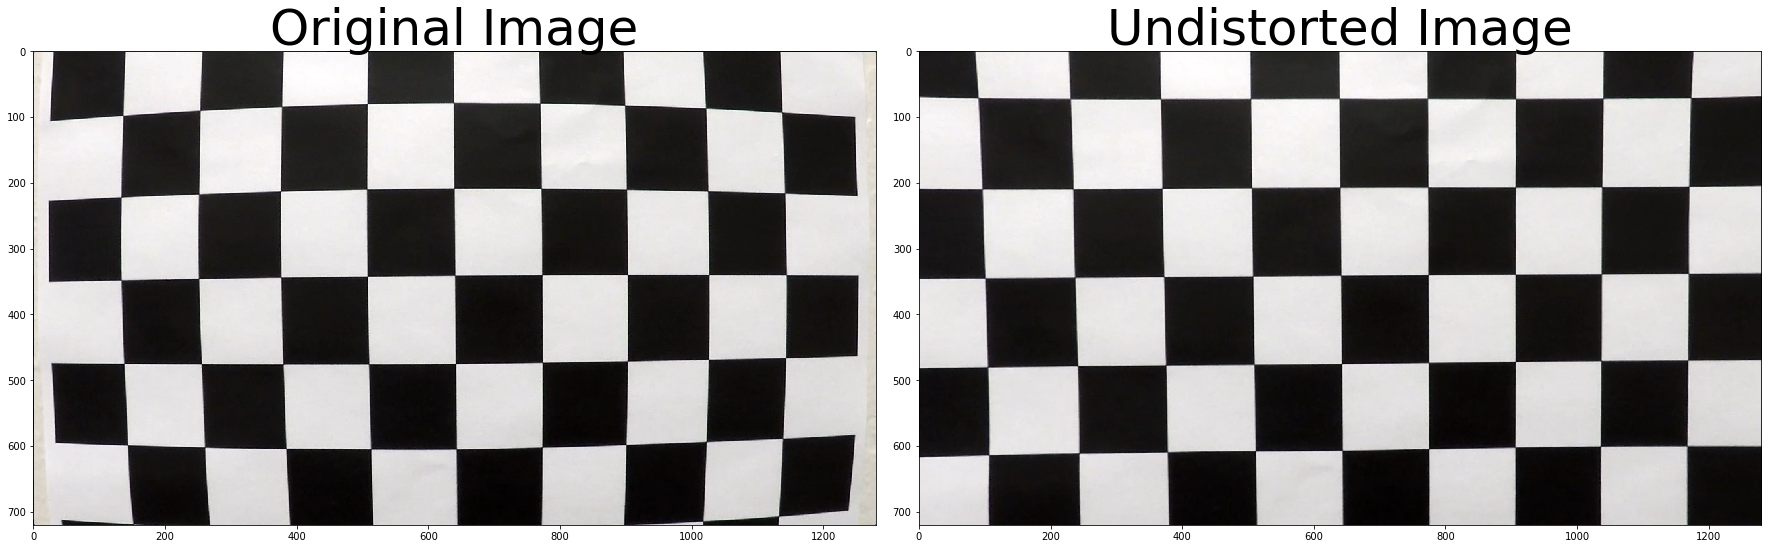

In [25]:
imagePaths = loadImagesFromFolder("camera_cal",["jpg"])
images = [ plt.imread(imgPath) for imgPath in imagePaths ]

imageToDistort = plt.imread('./camera_cal/calibration1.jpg')
imageShape = imageToDistort.shape
imageSize = (imageShape[1],imageShape[0])

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

#collect points

# 9 6 is the best setup for the most calibration pictures
for image in images:
    getImgAndObjectPoints(image,9,6,objpoints,imgpoints)

# for 1., 14. 9,5 found
getImgAndObjectPoints(images[0],9,5,objpoints,imgpoints)
getImgAndObjectPoints(images[13],9,5,objpoints,imgpoints)

result,objptsToDistort,imgptsToDistort,found = getImgAndObjectPoints(imageToDistort,9,5,objpoints,imgpoints)

if found==True:
    showOriginalAndUndistortedImage(result,objptsToDistort,imgptsToDistort)
#else:
#    print("notfound")

## 2. Apply a distortion correction to raw images.

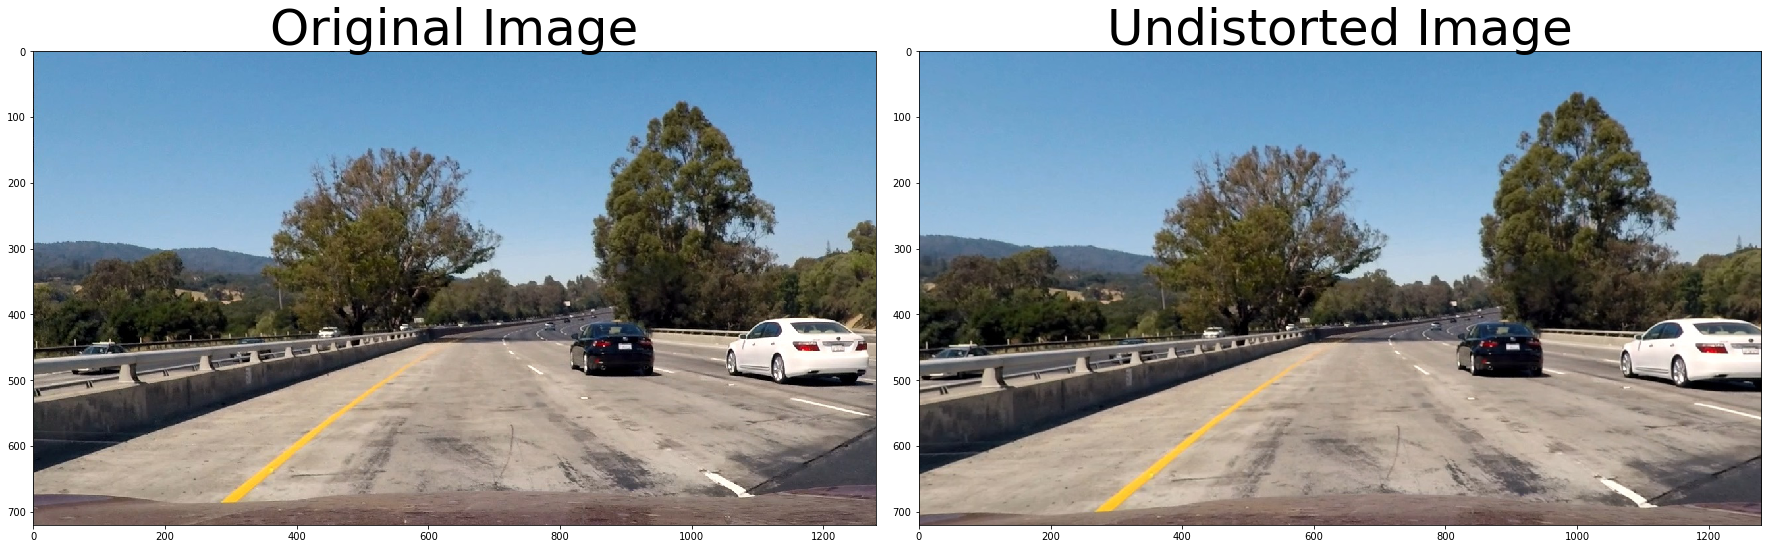

In [26]:
testImgToDistort = plt.imread('./test_images/test1.jpg')
cal_undistort(testImgToDistort,objpoints,imgpoints)
showOriginalAndUndistortedImage(testImgToDistort,objpoints,imgpoints)

## 3. Color transforms, gradients to create a thresholded binary image.

#### Can we found a better solution to find lanes on grayscaled or other color transformed images ?

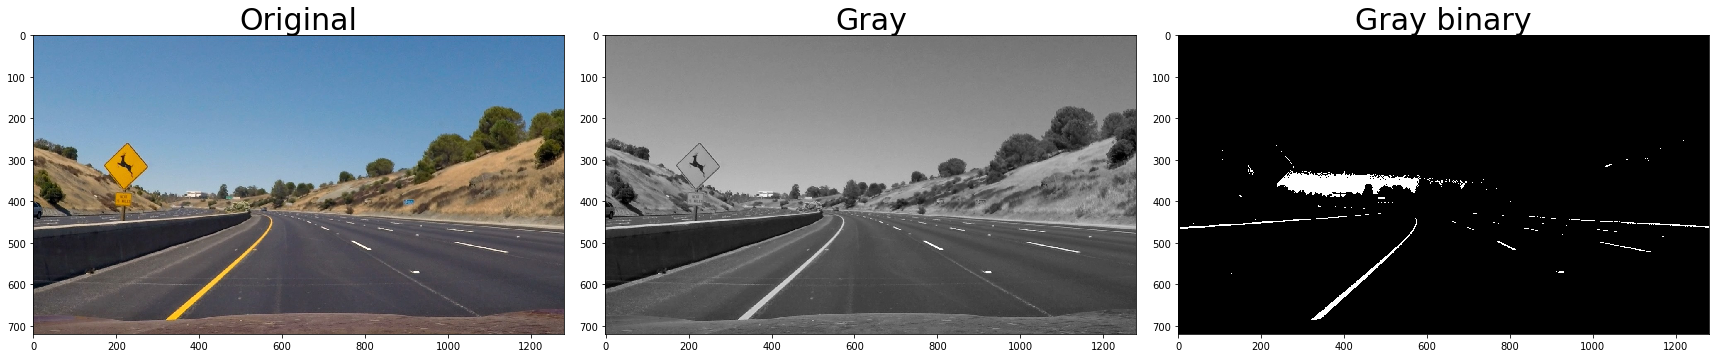

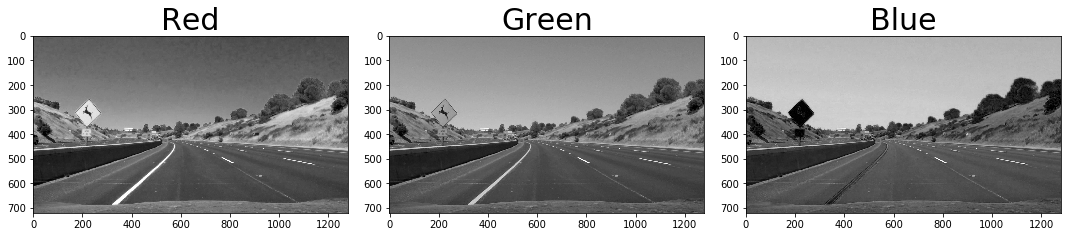

In [27]:
testImgToColorTransform = plt.imread('./test_images/test2.jpg')

thresHold = (180, 255)
gray = cv2.cvtColor(testImgToColorTransform, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresHold[0]) & (gray <= thresHold[1])] = 1


canv, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
canv.tight_layout()
ax1.set_title('Original', fontsize=30)
ax1.imshow(testImgToColorTransform)
ax2.set_title('Gray', fontsize=30)
ax2.imshow(gray,cmap='gray')
ax3.set_title('Gray binary', fontsize=30)
ax3.imshow(binary,cmap='gray')

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.imshow(gray,cmap='gray')
redChannel = testImgToColorTransform[:,:,0]
greenChannel = testImgToColorTransform[:,:,1]
blueChannel = testImgToColorTransform[:,:,2]

canv, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 9))
canv.tight_layout()
ax1.set_title('Red', fontsize=30)
ax1.imshow(redChannel,cmap='gray')
ax2.set_title('Green', fontsize=30)
ax2.imshow(greenChannel,cmap='gray')
ax3.set_title('Blue', fontsize=30)
ax3.imshow(blueChannel,cmap='gray')


#### The Red channel looks great! lets see it in binary

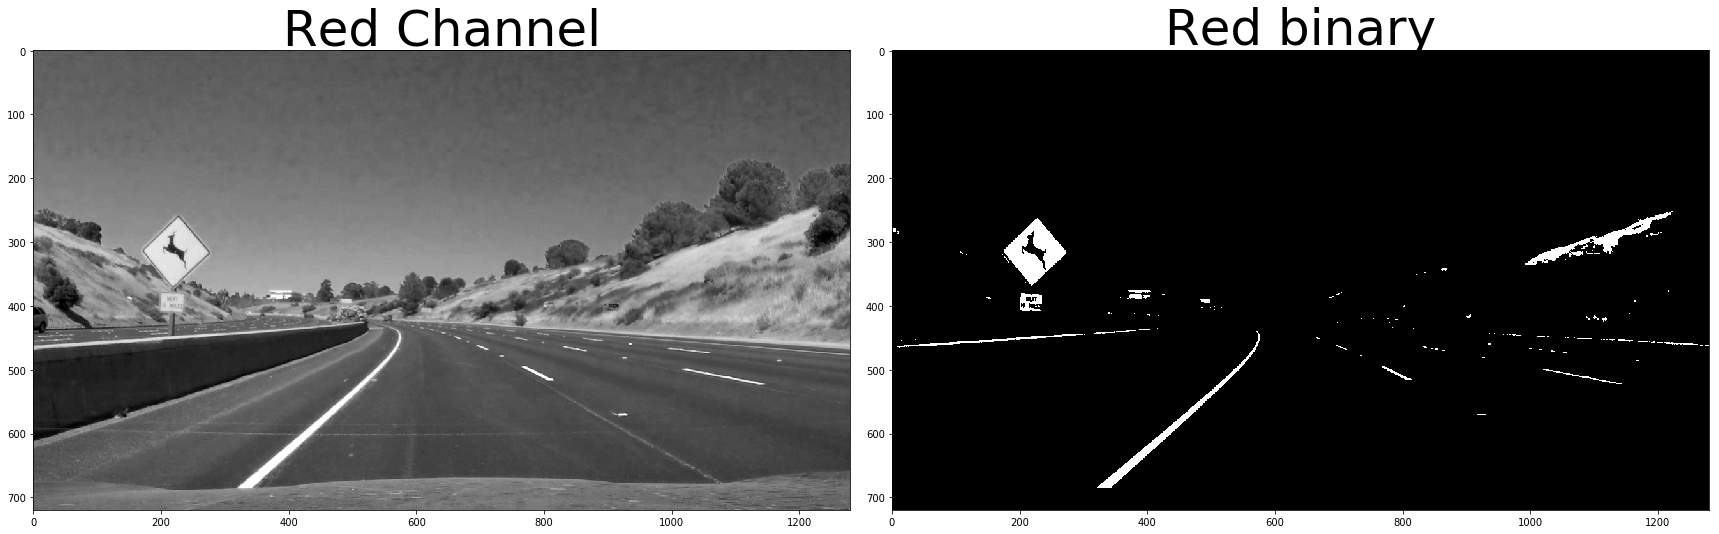

In [28]:
thresHoldToRed = (200, 255)
binaryRed = np.zeros_like(redChannel)
binaryRed[(redChannel > thresHoldToRed[0]) & (redChannel <= thresHoldToRed[1])] = 1


canv, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
canv.tight_layout()
ax1.set_title('Red Channel', fontsize=50)
ax1.imshow(redChannel,cmap='gray')
ax2.set_title('Red binary', fontsize=50)
ax2.imshow(binaryRed,cmap='gray')


#### Lets look at HLS channels

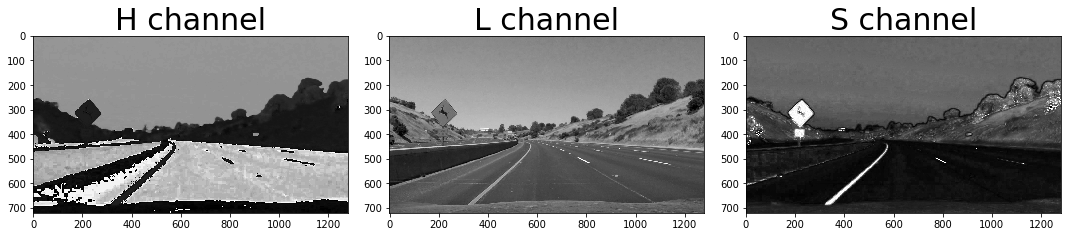

In [29]:
hlsChannels = cv2.cvtColor(testImgToColorTransform, cv2.COLOR_RGB2HLS)
hChannel = hlsChannels[:,:,0]
lChannel = hlsChannels[:,:,1]
sChannel = hlsChannels[:,:,2]

canv, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 9))
canv.tight_layout()
ax1.set_title('H channel', fontsize=30)
ax1.imshow(hChannel,cmap='gray')
ax2.set_title('L channel', fontsize=30)
ax2.imshow(lChannel,cmap='gray')
ax3.set_title('S channel', fontsize=30)
ax3.imshow(sChannel,cmap='gray')

#### The S channel picks up the lines well, so let's try applying a threshold there:

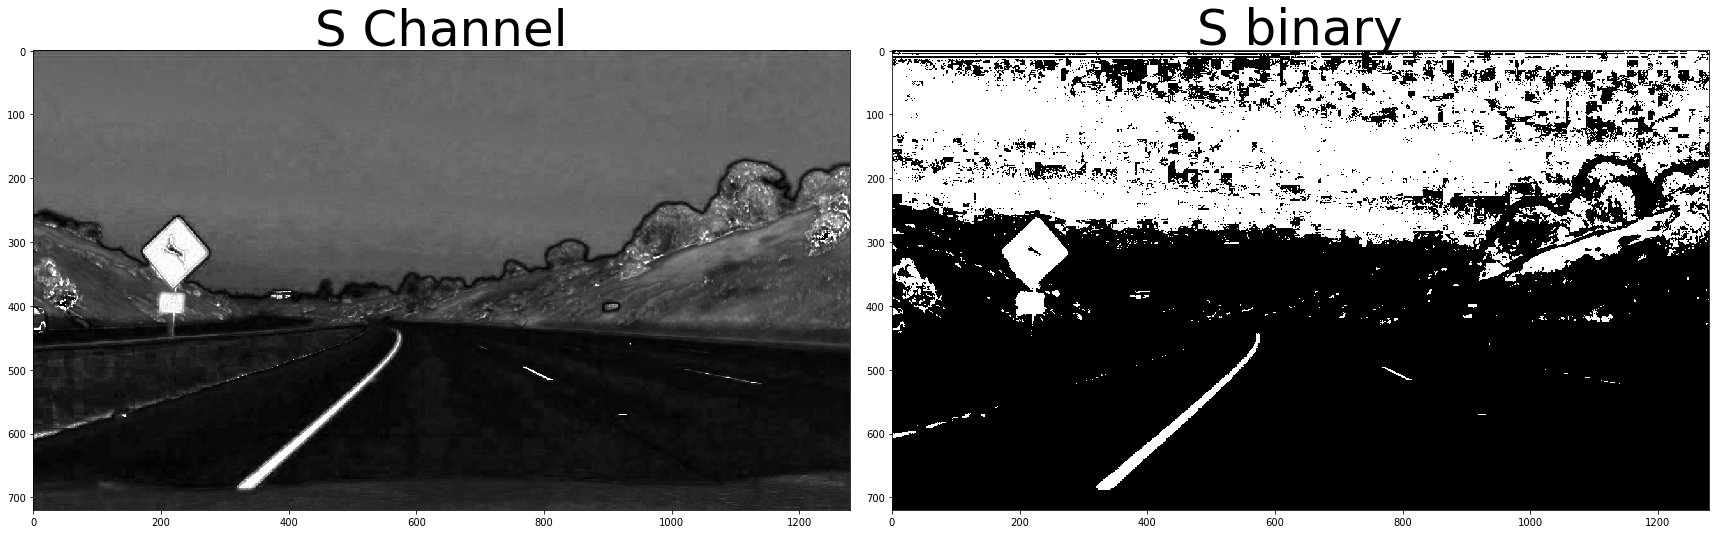

In [30]:
threshToSChannel = (100, 255)
sBinary = np.zeros_like(sChannel)
sBinary[(sChannel > threshToSChannel[0]) & (sChannel <= threshToSChannel[1])] = 1

canv, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
canv.tight_layout()
ax1.set_title('S Channel', fontsize=50)
ax1.imshow(sChannel,cmap='gray')
ax2.set_title('S binary', fontsize=50)
ax2.imshow(sBinary,cmap='gray')


#### Gradient Treshold, Sobel Operator, Applying Sobel

In [31]:
grad_binary = abs_sobel_thresh(testImgToColorTransform, orient='x', thresh_min=10, thresh_max=100)
# Plot the result
canv, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
canv.tight_layout()
ax1.imshow(testImgToColorTransform)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Magnitude of the gradient

In [32]:
mag_binary = tresholdedMagnitude(testImgToColorTransform, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
canv, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
canv.tight_layout()
ax1.imshow(testImgToColorTransform)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Direction of the gradient

In [33]:
dir_binary = tresholdedDirection(testImgToColorTransform, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
canv, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
canv.tight_layout()
ax1.imshow(testImgToColorTransform)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [34]:
testImage2 = plt.imread('./test_images/test2.jpg')
h,w = testImage2.shape[:2]

src = np.float32([ 
                (550, 450)
                ,(720, 450)
                ,(260, 680)
                ,(1160, 680)
                ])

dst = np.float32([ 
                (430, 0)
                ,(900, 0)
                ,(430, h)
                ,(900, h)
                ])
canv, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
canv.tight_layout()
ax1.set_title('Lane area', fontsize=20)
ax2.set_title('Lane area bird\'s eye view', fontsize=20)
#markerDotHelper(testImgToColorTransform,src)
markedImg=markerLineHelper(src,testImage2,ax1,True,True)
uN, M  = unwarp(testImage2,src,dst)
markerLineHelper(dst,uN,ax2,True,True)

hlsChannels = cv2.cvtColor(testImage2, cv2.COLOR_RGB2HLS)
sCT = hlsChannels[:,:,2]
threshToSChannel = (100, 255)
sTBinary = np.zeros_like(sCT)
sTBinary[(sCT > threshToSChannel[0]) & (sCT <= threshToSChannel[1])] = 1

unwarpedBinaryImage, M = unwarp(sTBinary,src,dst)
ax3.set_title('S channel', fontsize=20)
ax3.imshow(unwarpedBinaryImage,cmap='gray')

ax4.set_title('S channel Binary Bird\'s eye interesting area', fontsize=20)
r = markerLineHelper(dst,unwarpedBinaryImage,ax4,True,True)

## 5. Detect lane pixels and fit to find the lane boundary.

In [35]:
testImage = plt.imread('./test_images/test3.jpg')
img_size = (testImage.shape[1], testImage.shape[0])
redCha = testImage[:,:,0]
hlsC= cv2.cvtColor(testImage, cv2.COLOR_RGB2HLS)
sChan = hlsC[:,:,2]
lChan = hlsC[:,:,1]

threshToSC = (125, 255)
sBinary = np.zeros_like(sChan)
sBinary[(sChan > threshToSC[0]) & (sChan <= threshToSC[1])] = 1

threshToLC = (180, 255)
lBinary = np.zeros_like(lChan)
lBinary[(lChan > threshToLC[0]) & (lChan <= threshToLC[1])] = 1


threshToRC = (225, 255)
rBinary = np.zeros_like(redCha)
rBinary[(redCha > threshToRC[0]) & (redCha <= threshToRC[1])] = 1


h,w = testImage.shape[:2]

sourcePoints = np.float32([ 
                            (580, 450)
                            ,(680, 450)
                            ,(150, 680)
                            ,(1200, 680)
                            ])

destinationPoints = np.float32([ 
                            (430, 0)
                            ,(900, 0)
                            ,(430, h)
                            ,(900, h)
                            ])
'''
gradx = abs_sobel_thresh(imageParam, orient='x', thresh_min=10, thresh_max=255)
grady = abs_sobel_thresh(imageParam, orient='y',  thresh_min=25, thresh_max=255)
dir_binary = tresholdedDirection(imageParam, sobel_kernel=7, thresh=(0, 0.0777))

uGradx, M = unwarp(gradx,sourcePoints,destinationPoints)
uGrady, M = unwarp(grady,sourcePoints,destinationPoints)

uDir, M = unwarp(dir_binary,sourcePoints,destinationPoints)
'''
gradx = abs_sobel_thresh(testImage, orient='x', thresh_min=20, thresh_max=255)
uGradx, M = unwarp(gradx,sourcePoints,destinationPoints)
uSBinaryy, M = unwarp(sBinary,sourcePoints,destinationPoints)
uLBinaryy, M = unwarp(lBinary,sourcePoints,destinationPoints)
uRBinaryy, M = unwarp(rBinary,sourcePoints,destinationPoints)
cBinary = np.zeros_like(uSBinaryy)*255
#cBinary[( (uSBinaryy==1)) & (uRBinaryy==1) |  (uLBinaryy==1)] = 1
#cBinary[((uBinaryMag==1) | (uSBinaryy==1)) | (uRBinaryy==1) |  (uLBinaryy==1)] = 1

cBinary[( (uRBinaryy==1)) | (uGradx==1)] = 1

canv, (bx1,bx2,bx3) = plt.subplots(1, 3, figsize=(24, 9))
canv.tight_layout()
bx1.set_title('Combined channel Binary Bird\'s eye interesting area', fontsize=20)
bx2.set_title('Detected lane pixels with polynomial fit', fontsize=20)
#markerLineHelper(destinationPoints,cBinary,bx1,True,True)
bx1.imshow(cBinary,cmap='gray')
out_img = fit_polynomial(cBinary)
processor = LaneProcessor()
lanesOnImg = processor.process_image(testImage)
#drawLanesPipeline(testImgToSobel,combinedBinary,vertices)
bx2.imshow(lanesOnImg)

#plt.imshow(resultImg)

#### Polynomial fit values

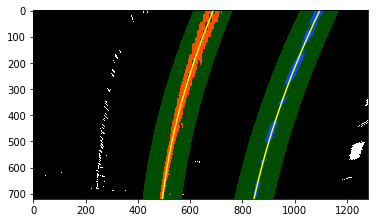

In [36]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(cBinary)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
resultIm = search_around_poly(cBinary,left_fit,right_fit)

#plt.imshow(result)

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [38]:
imageP = testImage#plt.imread('./test_images/test1.jpg')
img_size = (imageP.shape[1], imageP.shape[0])

sourcePoints = np.float32(
                [[(img_size[0] / 2) - 90, img_size[1] / 2 + 100],
                [((img_size[0] / 6) - 10), img_size[1]],
                [(img_size[0] * 5 / 6) + 60, img_size[1]],
                [(img_size[0] / 2 + 90), img_size[1] / 2 + 100]])
destinationPoints = np.float32(
                [[(img_size[0] / 4), 0],
                [(img_size[0] / 4), img_size[1]],
                [(img_size[0] * 3 / 4), img_size[1]],
                [(img_size[0] * 3 / 4), 0]])

Canny = cv2.Canny(imageP,100,150)
unwarpedCanny, M = unwarp(Canny,sourcePoints,destinationPoints)

imageParam = imageP#cal_undistort(imageP,objpoints,imgpoints)

thresHoldGray = (200, 255)
gray = cv2.cvtColor(imageP, cv2.COLOR_RGB2GRAY)
gBinary = np.zeros_like(gray)
gBinary[(gray > thresHoldGray[0]) & (gray <= thresHoldGray[1])] = 1

redCha = imageParam[:,:,0]
hlsC= cv2.cvtColor(imageParam, cv2.COLOR_RGB2HLS)
sChan = hlsC[:,:,2]
lChan = hlsC[:,:,1]

threshToSC = (220, 255)
sBinary = np.zeros_like(sChan)
sBinary[(sChan > threshToSC[0]) & (sChan <= threshToSC[1])] = 1

threshToLC = (199, 255)
lBinary = np.zeros_like(lChan)
lBinary[(lChan > threshToLC[0]) & (lChan <= threshToLC[1])] = 1


threshToRC = (200, 255)
rBinary = np.zeros_like(redCha)
rBinary[(redCha > threshToRC[0]) & (redCha <= threshToRC[1])] = 1
h,w = imageParam.shape[:2]    

uSBinaryy, M = unwarp(sBinary,sourcePoints,destinationPoints)
uRBinaryy, M = unwarp(rBinary,sourcePoints,destinationPoints)
uGBinaryy, M = unwarp(gBinary,sourcePoints,destinationPoints)

cBinary = np.zeros_like(uSBinaryy)*255
unCanBin = np.zeros_like(unwarpedCanny)
unCanBin[(unwarpedCanny > 120) & (unwarpedCanny <= 255)]=1

cBinary[(unCanBin==1)&((uRBinaryy==1) | (uSBinaryy==1))  ] = 1
vehiclePos ,left_curverad, right_curverad = measure_curvature_real(cBinary,leftx, lefty, rightx, righty)
print('Left radius of curvature:',left_curverad)
print('Right radius of curvature:',right_curverad)
print('Vehicle Position from center:',vehiclePos)
print('Curve radius:',(left_curverad+right_curverad)/2)
'''
cv2.putText(imageP, 'Radius of curvature = ' + '{:03.0f}'.format((left_curverad+right_curverad)/2) + '(m)', (20,60), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 2, cv2.FILLED)
leftOrRight=''
if vehiclePos<0:
    leftOrRight='left'
else:
    leftOrRight='right'
    
cv2.putText(imageP, 'Vehicle is ' + '{:0.3f}'.format(abs(vehiclePos)) + '(m) '+leftOrRight+' of center', (20,120), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 2, cv2.FILLED)
plt.imshow(imageP)
'''

Left radius of curvature: 831.723535711
Right radius of curvature: 284.002271833
Vehicle Position from center: -0.155158642331
Curve radius: 557.862903772


"\ncv2.putText(imageP, 'Radius of curvature = ' + '{:03.0f}'.format((left_curverad+right_curverad)/2) + '(m)', (20,60), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 2, cv2.FILLED)\nleftOrRight=''\nif vehiclePos<0:\n    leftOrRight='left'\nelse:\n    leftOrRight='right'\n    \ncv2.putText(imageP, 'Vehicle is ' + '{:0.3f}'.format(abs(vehiclePos)) + '(m) '+leftOrRight+' of center', (20,120), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), 2, cv2.FILLED)\nplt.imshow(imageP)\n"

## 7. Warp the detected lane boundaries back onto the original image.

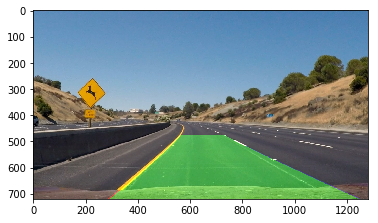

In [39]:
testIma = plt.imread('./test_images/test2.jpg')

prc=LaneProcessor()
lanesOnImg = prc.process_image(testIma)
plt.imshow(lanesOnImg)

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

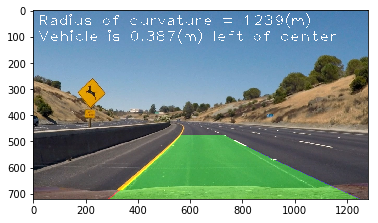

In [21]:
testIma = plt.imread('./test_images/test2.jpg')
prc=LaneProcessor()
prc.changeDataWriteState()
lanesOnImg = prc.process_image(testIma)
#cv2.imwrite("f.jpg", lanesOnImg)
plt.imshow(lanesOnImg)


In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

prc=LaneProcessor()
prc.changeDataWriteState()
prc.tresholdToFit=8
white_output = './project_videores.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(prc.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_videores.mp4
[MoviePy] Writing video ./project_videores.mp4


100%|█████████▉| 1260/1261 [03:27<00:00,  6.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_videores.mp4 

CPU times: user 1min 25s, sys: 2.57 s, total: 1min 27s
Wall time: 3min 30s
